<a href="https://colab.research.google.com/github/Ron-Rocks/Class-Activation-Map/blob/master/CAM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Project overview:

In this notebook we will be loading the data which contains 120 different dog breeds with their images.

We will first build an image classification model then,train it.

Then we show the heatmaps to know exactly where the model is looking in the image.

#CAM (Class Activation Map):
>It is basically a technique used to identify a specific part of the image which is relevant to the class predicted by the image classifier

In [0]:
from google.colab import drive
drive.mount('/content/drive')

In [0]:
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.layers import Dense,GlobalAveragePooling2D,Flatten,Conv2D,Dropout
from tensorflow.keras.models import Model,load_model
from tensorflow.keras.callbacks import ModelCheckpoint
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import scipy

# Loading The dataset
Here I am retreiving the data Stored in my drive as Numpy Arrays:
> x contains the actual image data

>y contains the labels

>decoder contains the name of the breed.

In [0]:
x = np.load("/content/drive/My Drive/x.npy")
y = np.load("/content/drive/My Drive/y.npy")
decoder = np.load("/content/drive/My Drive/decoder.npy")

Now, we have to convert our labels into one hot vectors using 

**to_categorical**









In [0]:
y = tf.keras.utils.to_categorical(y)

This is how the shape of our data looks like -->

In [7]:
print("X shape : ",x.shape)
print("Y shape : ",y.shape)
print("Decoder shape : ",decoder.shape)

X shape :  (20580, 224, 224, 3)
Y shape :  (20580, 120)
Decoder shape :  (120,)


# Image Classifier Model :
We will be using transfer learning to make an Image classification model



First we will get the VGG16 model excluding the last dense layer:

Model Architecture -->

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
58892288/58889256 [==============================] - 2s 0us/step


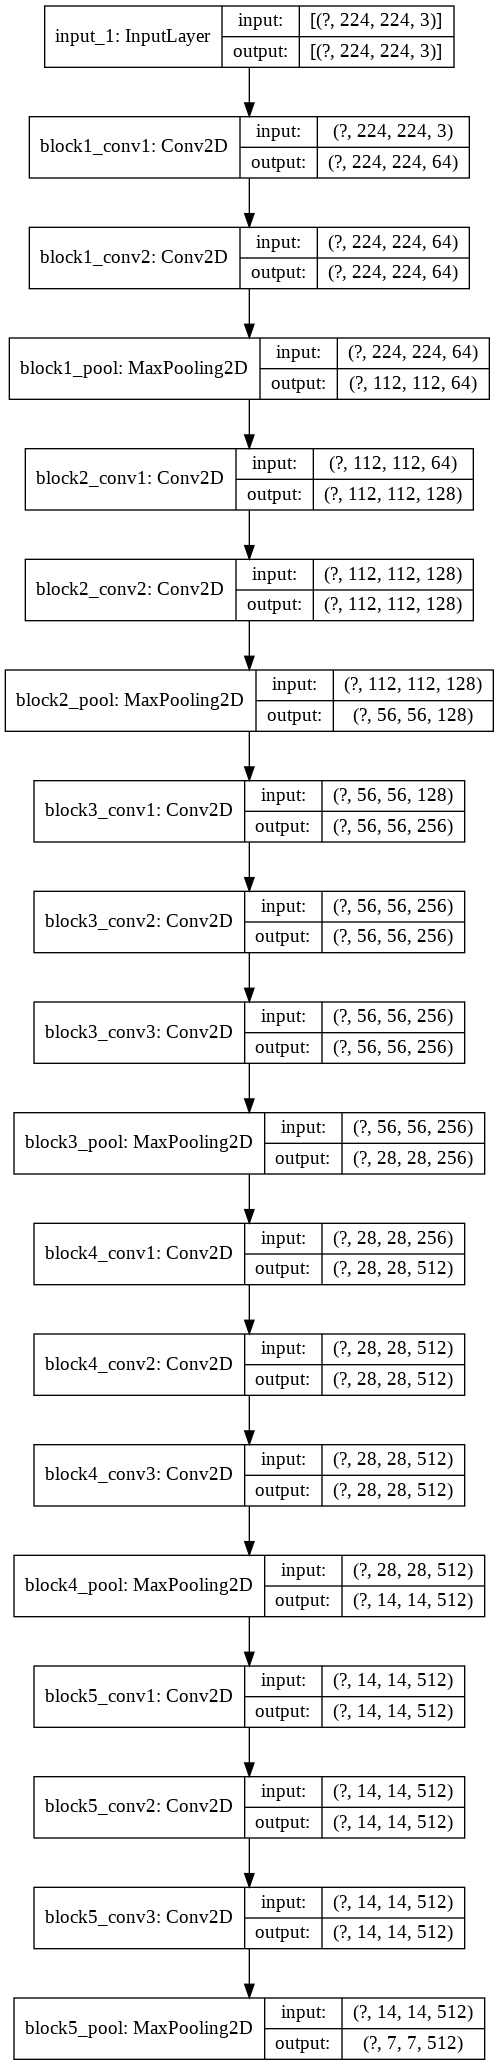

In [8]:
vgg16 = VGG16(input_shape = (224,224,3),include_top = False)

tf.keras.utils.plot_model(vgg16,show_shapes=True)

Next, we will freeze the whole vgg16 model so that its weights do not change while training:

In [0]:
for layer in vgg16.layers:
    layer.trainable = False

Now, we will add some Conv layers followed by a GlobalAveragePooling2D layer.

Then, we will ad the final dense layer with  *softmax*  activation.

In [0]:
x = Conv2D(32,3,padding="same")(vgg16.layers[-1].output)
x = Dropout(0.3)(x)
x = Conv2D(64,3,padding = "same")(x)
x = GlobalAveragePooling2D(data_format="channels_last")(x)
x = Dense(120,activation="softmax")(x)
model = Model(vgg16.input,x)
model.compile(loss="categorical_crossentropy",optimizer="adam",metrics=["accuracy"])

This is how the Model Architecture looks like -->

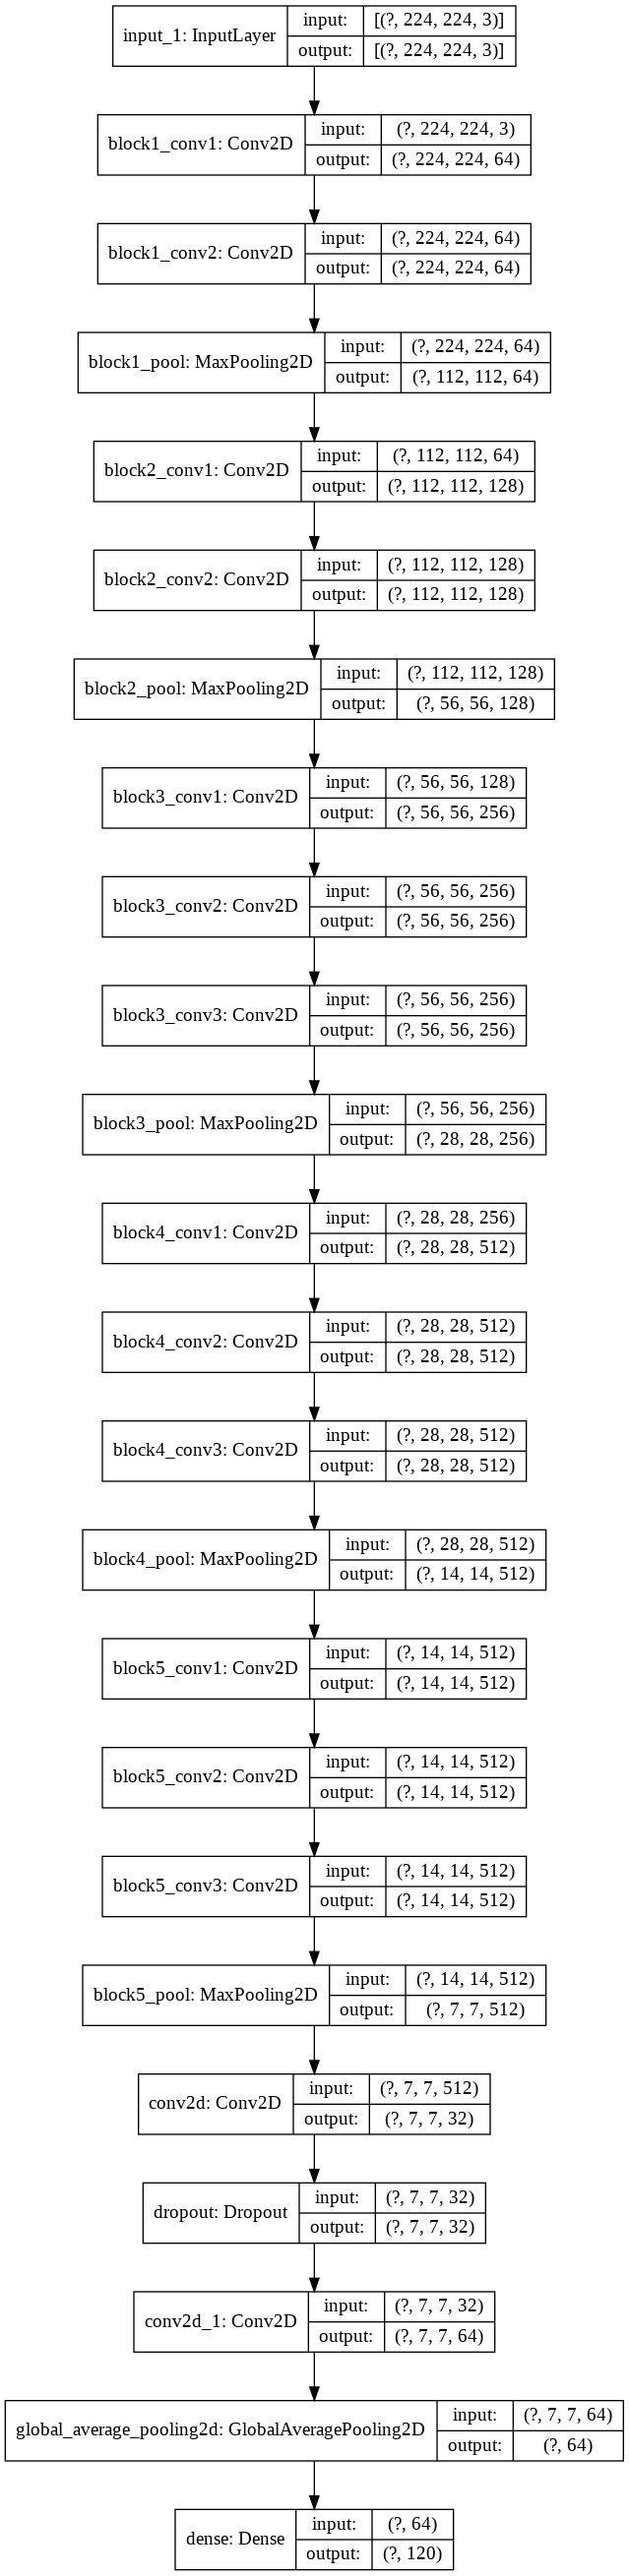

In [11]:
tf.keras.utils.plot_model(model,show_shapes=True)

In [0]:
checkpoint = ModelCheckpoint(filepath="/content/drive/My Drive/breedModels/model.{epoch:02d}-{val_loss:.2f}.hdf5",save_best_only=True)
model.fit(trainX,trainY,validation_data  = (testX,testY),epochs = 20,callbacks=[checkpoint])

In [0]:
model = load_model("/content/drive/My Drive/breedModels/model.09-2.47.hdf5")
model.summary()

#Building the actual Heatmap:

**To get the heatmaps we have to take the dot product of the weights of the dense layer and the features detected by the last conv layer**

To get the features detected, we are bulding another model which will take the image as the input and will give 2 Ouputs:

1. The features

2. And the actual probabilities of the breeds

In [0]:
# Building a model which will provide us with the features detected by the last conv layer and the actual ouput of the last dense layer
heatmapModel = Model(inputs = model.input,outputs = [model.layers[-3].output,model.output]) 

features,output = heatmapModel.predict(testX[:25])
print(features.shape)

Now, we will get the weights of the last dense layer:

In [0]:
# Getting the weights of the last dense layer
denseWeights = model.layers[-1].get_weights()
denseWeights = denseWeights[0]
print(denseWeights.shape)


Lastly, we will take the dot product of the weights and features of the predicted class

>So,what is happening is,we  are multiplying the features with its corresponding weights

>while fitting, the less important features will have very low weights .So,when we multiply the feature with the weights ,the less important features will atomatically get filtered out.

![alt text](https://drive.google.com/uc?id=1GP9Di9Ftz9G-E75IvJpavSa-LMNxlFKo)

>In the results below the red areas are where the model is paying the most attention and the blue area indicates least attention

(25, 7, 7, 64)
(64, 120)


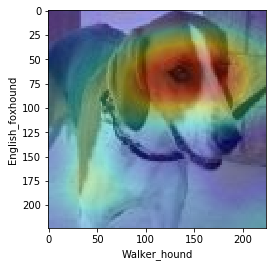

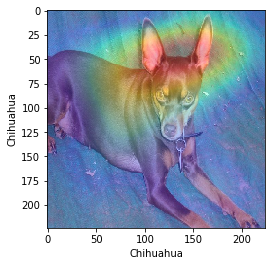

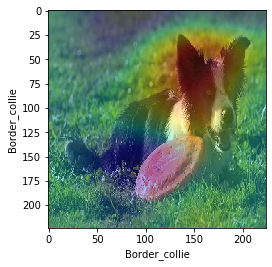

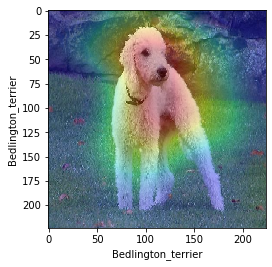

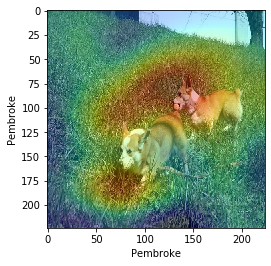

In [0]:

for i in range(5):
    feature = features[i,:,:,:]
    feature = scipy.ndimage.zoom(feature,(32,32,1))

    predicted = np.argmax(output[i])

    weights = denseWeights[:,predicted] # Getting the weight of the predicted class
    heatmap = np.dot(feature,weights) # Dot product of the feature and the weights of the predicted class

    label = decoder[predicted]

    plt.figure()
    plt.xlabel(label)
    plt.ylabel(decoder[np.argmax(testY[i])])
    # X axis label is the predicted label
    # Y axis label is the actual label  

    plt.imshow(heatmap,cmap = "jet",alpha=1)
    plt.imshow(testX[i],alpha = 0.7)
